In [1]:
from scipy.signal import butter, filtfilt, find_peaks, freqz, sosfilt
import scipy as sp
import matplotlib.pyplot as plt 
%matplotlib widget
import numpy as np 
import pandas as pd 
import gc
import cupy as cp
import multiprocessing as mp
from multiprocessing import shared_memory, Process, Lock, Pool
from multiprocessing import cpu_count, current_process
import ray

sys.path.insert(0, '../../drlib')
import drlib as dr

madCor = 1.4826

In [ ]:
#Ben's code to convert config file to parsedList and configDic

from collections import namedtuple
from datetime import datetime
from multiprocessing import Pool
import bisect
import configparser
import multiprocessing as mp
import numpy as np
import time
import matplotlib.pyplot as plt 
import h5py as h5
import os
import pandas as pd
import sys

"""
Convert the float parameters in the config file to floats
Parameters:
   aString: The string in the config file
Returns:
    holder (1D list): List of floats
"""
def getFloatBounds(aString):
    holder = aString[aString.index('[')+1:aString.index(']')]
    holder = holder.split(',')
    holder = [float(x) for x in holder]
    if len(holder) % 2 != 0:
        raise Exception('LENGTH OF CONSTRAINT IS NOT A MULTIPLE OF TWO')
    return holder

"""
Convert the date parameters in the config file to floats
Parameters:
   aString: The date string in the config file
Returns:
    holder (1D list): List of datetime objects written as month/day/year hour:minute:second.microseconds
"""
def getDateBounds(aString):
    holder = aString[aString.index('[')+1:aString.index(']')]
    holder = holder.split(',')
    holder = [datetime.strptime(x.strip(), '%m/%d/%Y %H:%M:%S.%f')  for x in holder]
    if len(holder) % 2 != 0:
        raise Exception('LENGTH OF CONSTRAINT IS NOT A MULTIPLE OF TWO')
    return holder

"""
Take in a config file and return a dictionary of bounds
Parameters:
   configFile: The config file
   configName: The name of the configuration setup
Returns:
    configDict (dictionary): Dictionary of bounds
"""
def getAllBounds(configFile, configName):
    configSetup = configparser.ConfigParser()
    configSetup.read(configFile)
    configDict = {}
    tempBounds = getFloatBounds(configSetup[configName]['Temperature'])
    freqBounds = getFloatBounds(configSetup[configName]['Frequency'])
    dateBounds = getDateBounds(configSetup[configName]['Date'])
    antWestBounds =  getFloatBounds(configSetup[configName]['AntennaWest'])
    antVertBounds = getFloatBounds(configSetup[configName]['AntennaVert'])
    antSouthBounds = getFloatBounds(configSetup[configName]['AntennaSouth'])
    antThetaBounds = getFloatBounds(configSetup[configName]['AntennaTheta'])
    antPhiBounds = getFloatBounds(configSetup[configName]['AntennaPhi'])
    measChoice = configSetup['TEST']['Measurement']
    configDict['Temp'] = tempBounds 
    configDict['Freq'] = freqBounds
    configDict['Date'] = dateBounds
    configDict['Ant'] = (antWestBounds, antVertBounds, antSouthBounds, antThetaBounds, antPhiBounds)
    configDict['Choice'] = measChoice
    return configDict

"""
Return the indices in the "database" that fall within the specified
bound. This function assumes that the database is ordered by the 
parameter being searched for.
Parameters:
   val: The value in the config file
   parsedList: List of the parameter being searched for (e.g. date/temperature/antenna position)
Returns:
    holderIndices: List of all the indices in the sorted list that fall in the bounds
"""
def parseOnce(val, parsedList):
    #print('VAL: ' + str(val))
    if len(parsedList) == 0:
        return []
    
    holderIndices = []
    if val[0] > val[1]:
        print('CONFUSED ORDERING')
        return []
    if val[0] == -1:
        startIndex = 0
    elif val[0] < parsedList[0]:
        startIndex = 0
    elif val[0] > parsedList[-1]:
        print('EMPTY LIST')
        return []
    else:
        startIndex = bisect.bisect_left(parsedList, val[0])
    if val[1] == -1:
        endIndex = len(parsedList)
    elif val[1] > parsedList[-1]:
        endIndex = len(parsedList)
    else:
        endIndex = bisect.bisect_right(parsedList, val[1])
    
    [holderIndices.append(x) for x in range(startIndex, endIndex)]    
    return holderIndices

"""
Obtain all the datasets that fall within the bounds given in the config
file.
Parameters:
   configFile: The name of the configuration file
   configName: The name of the configuration setup in the config file 
Returns:
    parsedList: List of all the parsed data files defined as a list of tuples
                of the form ((file number, save number), date, temperature, antenna position).)
                    - Date is a datetime object
                    - Antenna position is a tuple of the form (west, vertical, south, theta, phi)

"""
def getParsedList(configFile, configName):
    #dbFile = '/group/tysongrp/SearchableDatabase.txt'
    dbFile = './SearchableDatabase.txt'

    allData = []
    configDict = getAllBounds(configFile, configName)
    #print('BOUNDS: ' + str(configDict))
    with open(dbFile, 'r') as f:
        f.readline()
        for line in f:
            holder = line.split()
            holder = [x.replace(',', '') if counter > 0 else x for counter, x in enumerate(holder)]
            try:
                dateVal = datetime.strptime(holder[1] + ' ' + holder[2], '%Y-%m-%d %H:%M:%S.%f')
            except:
                 dateVal = datetime.strptime(holder[1] + ' ' + holder[2], '%Y-%m-%d %H:%M:%S')

            tempVal = float(holder[3])
            antPos = (float(holder[4][1:]), float(holder[5]), float(holder[6]), float(holder[7]), float(holder[8][:-1]))
            fileNum = float(holder[0][1:holder[0].index(',')])
            runNum = float(holder[0][holder[0].index(',')+1:-2])
            allData.append(((fileNum, runNum), dateVal, tempVal, antPos))
    
    holderIndices = []
    allData = sorted(allData, key = lambda x: x[1])
    parsedList = allData
    for val in np.reshape(configDict['Date'], (-1, 2)):
        [holderIndices.append(x) for x in parseOnce(val, [x[1] for x in parsedList])]
    
    holderIndices = np.asarray([*set(holderIndices)])
    parsedList = [parsedList[x] for x in holderIndices]
    

# configDict['Ant'] = (antWestBounds, antVertBounds, antSouthBounds, antThetaBounds, antPhiBounds)
# allData.append(((fileNum, runNum), dateVal, tempVal, antPos, antPos))

    for antSortVal in range(len(configDict['Ant'])):
        parsedList = sorted(parsedList, key = lambda x: x[3][antSortVal])
        holderIndices = []
        for val in np.reshape(configDict['Ant'][antSortVal], (-1, 2)):
            [holderIndices.append(x) for x in parseOnce(val, [x[3][0] for x in parsedList])]

        holderIndices = np.asarray([*set(holderIndices)])
        parsedList = [parsedList[x] for x in holderIndices]

    parsedList = sorted(parsedList, key = lambda x: x[2])
    holderIndices = []
    for val in np.reshape(configDict['Temp'], (-1, 2)):
        [holderIndices.append(x) for x in parseOnce(val, [x[2] for x in parsedList])]
    
    holderIndices = np.asarray([*set(holderIndices)])
    parsedList = [parsedList[x] for x in holderIndices]  
    
    parsedList = sorted(parsedList, key=lambda x: (x[0][0], x[0][1]))
    return parsedList, configDict
    #[print(x) for x in parsedList]


In [161]:
freqsAll = np.load('./run1_freqData_avgAll11776Spectra_gitignore.npy')
antDataAll = np.load('./run1_antData_avgAll11776Spectra_gitignore.npy')[1:]
termDataAll = np.load('./run1_termData_avgAll11776Spectra_gitignore.npy')[1:]

freqStart = 50.0 #MHz
idxStart = int(freqStart/freqsAll[-1] * len(freqsAll))

print('Starting frequency = ', freqStart, 'MHz')
print('Starting index = ', idxStart)

#default arrays are in watts and trimmed
freqs = freqsAll[idxStart:]
antSpec = dr.fft2Watts(antDataAll)[idxStart:]
termSpec = dr.fft2Watts(termDataAll)[idxStart:]


Starting frequency =  50.0 MHz
Starting index =  1398101


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5.6603108175258616e-12
17 candidates (dumb limit)


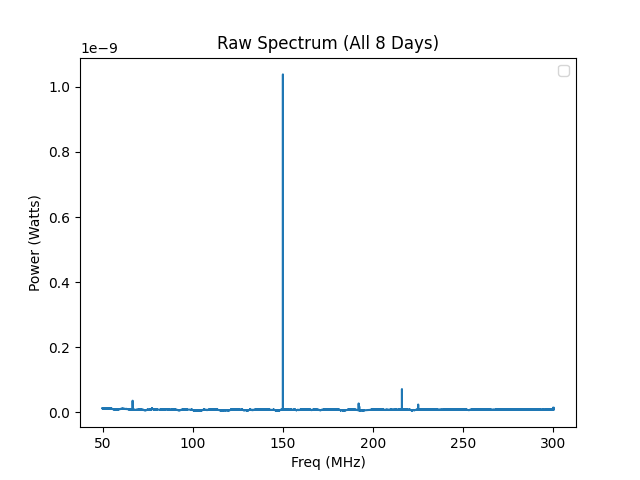

In [162]:
#plot raw averaged spectrum (all data)

dumbLimit = (antSpec.std()*5) + antSpec.mean()
print((antSpec.std()*5))
print((antSpec > dumbLimit).sum(), "candidates (dumb limit)")
%matplotlib widget
plt.close('all')
plt.figure()
plt.title('Raw Spectrum (All 8 Days)')
plt.plot(freqs, antSpec)
#plt.plot((freqStart, 300),(dumbLimit,dumbLimit), label = 'mean + 5 * STD')
plt.xlabel('Freq (MHz)')
plt.ylabel('Power (Watts)')
plt.legend(loc = "upper right")

Antenna limit (std) = 1.875897475047081e-12 Watts
filtered raw antenna data has  50 candidates (std)
Antenna limit (mad) = 1.234606335112927e-14 Watts
filtered raw antenna data has  1944 candidates (mad)
Terminator limit (std) = 1.802678542587686e-12 Watts
filtered raw terminator data has  8 candidates (std)
Terminator limit (mad) = 1.3744992050293004e-14 Watts
filtered raw terminator data has  191 candidates (mad)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


"\nplt.figure()\nplt.title('Zoom Filtered Antenna Spectrum (All 8 Days)')\nplt.plot(freqs, antSpecFiltered)\nplt.plot((freqStart, 300),(antLimit, antLimit))\nplt.xlabel('Freq (MHz)')\nplt.ylabel('Filtered Power (Watts)')\nplt.ylim(-2e-13, 2e-13)"

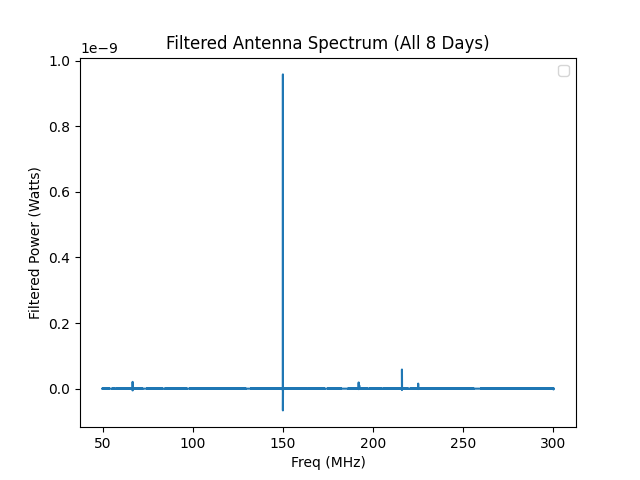

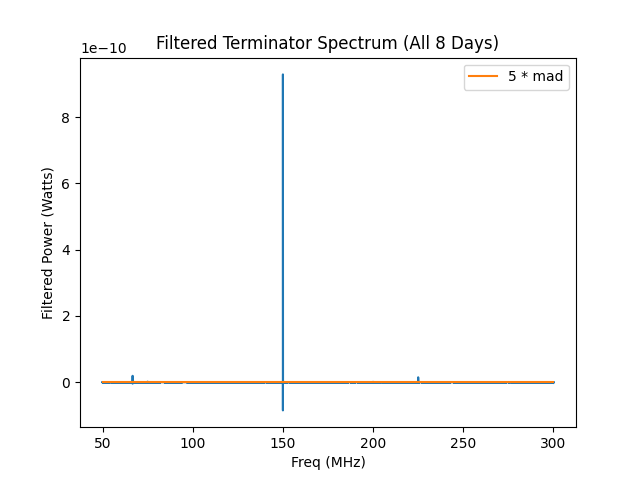

In [163]:
#filter and plot with 5sigma limit. Note these are not gain corrected!!!

nSigma = 5

antSpecFiltered = dr.filterSpec(antSpec)
antMad = sp.stats.median_abs_deviation(antSpecFiltered)
antStd = np.std(antSpecFiltered)
antLimitMad = nSigma * antMad * madCor
antLimitStd = nSigma * antStd

termSpecFiltered = dr.filterSpec(termSpec, fc_numBins=30, order = 1)
termMad = sp.stats.median_abs_deviation(termSpecFiltered)
termStd = np.std(termSpecFiltered)
termLimitMad = nSigma * termMad * madCor
termLimitStd = nSigma * termStd

nCandidatesAntStd = (antSpecFiltered > antLimitStd).sum()
print('Antenna limit (std) =', antLimitStd, 'Watts')
print('filtered raw antenna data has ', nCandidatesAntStd, 'candidates (std)')
nCandidatesAntMad = (antSpecFiltered > antLimitMad).sum()
print('Antenna limit (mad) =', antLimitMad, 'Watts')
print('filtered raw antenna data has ', nCandidatesAntMad, 'candidates (mad)')

nCandidatesTermStd = (termSpecFiltered > termLimitStd).sum()
print('Terminator limit (std) =', termLimitStd, 'Watts')
print('filtered raw terminator data has ', nCandidatesTermStd, 'candidates (std)')
nCandidatesTermMad = (termSpecFiltered > termLimitMad).sum()
print('Terminator limit (mad) =', termLimitMad, 'Watts')
print('filtered raw terminator data has ', nCandidatesTermMad, 'candidates (mad)')


%matplotlib widget
plt.close('all')

plt.figure()
plt.title('Filtered Antenna Spectrum (All 8 Days)')
plt.plot(freqs, antSpecFiltered)
#plt.plot((freqStart, 300),(antLimitMad, antLimitMad), label = 'mean + 5*1.48*MAD')
plt.xlabel('Freq (MHz)')
plt.ylabel('Filtered Power (Watts)')
plt.legend(loc = "upper right")

plt.figure()
plt.title('Filtered Terminator Spectrum (All 8 Days)')
plt.plot(freqs, termSpecFiltered)
plt.plot((freqStart, 300),(termLimitMad, termLimitMad), label = '5 * mad')
plt.xlabel('Freq (MHz)')
plt.ylabel('Filtered Power (Watts)')
plt.legend(loc = "upper right")


'''
plt.figure()
plt.title('Zoom Filtered Antenna Spectrum (All 8 Days)')
plt.plot(freqs, antSpecFiltered)
plt.plot((freqStart, 300),(antLimit, antLimit))
plt.xlabel('Freq (MHz)')
plt.ylabel('Filtered Power (Watts)')
plt.ylim(-2e-13, 2e-13)'''

In [ ]:
#create rolling MAD limit
'''
antSpecFiltered = dr.filterSpec(antSpec)
antSpecRolling = np.lib.stride_tricks.sliding_window_view(antSpecFiltered, 1000)
antRollingMad = sp.stats.median_abs_deviation(antSpecFiltered, axis = 0)
antLimit = 5 * antRollingMad
'''
termSpecFiltered = dr.filterSpec(termSpec)
termSpecRolling = np.lib.stride_tricks.sliding_window_view(termSpecFiltered, 100)

termRollingMad = sp.stats.median_abs_deviation(termSpecRolling, axis = 1)
print(termRollingMad)
termLimit = 5 * termRollingMad


plt.figure()
plt.title('Filtered Terminator Spectrum (All 8 Days)')
plt.plot(freqs, termSpecFiltered)
plt.plot(freqs[99:], termLimit)
#plt.plot(, label = '5 * rolling MAD')
plt.xlabel('Freq (MHz)')
plt.ylabel('Filtered Power (Watts)')
plt.legend()



'''
nCandidatesAnt = (antSpecFiltered > antLimit).sum()
print('Antenna limit =', antLimit, 'Watts')
print('filtered raw antenna data has ', nCandidatesAnt, 'candidates')
nCandidatesTerm = (termSpecFiltered > termLimit).sum()
print('Terminator limit =', termLimit, 'Watts')
print('filtered raw terminator data has ', nCandidatesTerm, 'candidates')
'''

In [ ]:
termSpecFiltered = dr.filterSpec(termSpec)
termSpecRolling = np.lib.stride_tricks.sliding_window_view(termSpecFiltered, 10, subok=True)

madArr = np.zeros(termSpecRolling)
#for window in termSpecRolling:
    

In [ ]:
#filter, remove center spur. 
# plot with 5sigma limit. Note these are not gain corrected!!!

#set center interleaving spur to it's negbor. See spur hunting sheet for these indicies
antSpecClean = (antSpec)

idxInterleaving = range(4194301-idxStart,4194306-idxStart)
for i in idxInterleaving:
    antSpecClean[i] =  antSpecClean[i+5]

antSpecCleanFilter = dr.filterSpec(antSpecClean)

antMAD = (sp.stats.median_abs_deviation(antSpecCleanFilter))
antLimit = 5 * antMAD
print('limit = ', antLimit, 'Watts')

nCandidates = (antSpecCleanFilter > antLimit).sum()
print('filtered raw data has ', nCandidates, 'candidates')




plt.figure()
plt.plot(freqs, dr.filterSpec(antSpecClean))
plt.plot((freqStart, 300),(antLimit, antLimit))


'''
antLimit = dr.fft2Watts(5 * sp.stats.median_abs_deviation(dr.filterSpec(antDataAll[idxStart:idxStart + 1000])))

nCandidates = (filteredAntSpecWatts > antLimit).sum()
print('filtered raw data has ', nCandidates, 'candidates')

%matplotlib widget
plt.close('all')

plt.figure()
plt.title('Filtered Spectrum (All 8 Days)')
plt.plot(freqs[idxStart:], filteredAntSpecWatts)
plt.xlabel('Freq (MHz)')
plt.ylabel('Filtered Power (Watts)')


plt.figure()
plt.title('Zoom Filtered Spectrum (All 8 Days)')
plt.plot(freqs[idxStart:], filteredAntSpecWatts)
plt.plot((freqStart, 300),(antLimit, antLimit))
plt.xlabel('Freq (MHz)')
plt.ylabel('Filtered Power (Watts)')
plt.ylim(-2e-13, 2e-13)
'''

mean  =  -0.00010830693938838158
mad * 1.48 =  1.0247776295895656
std =  1.081563216143801


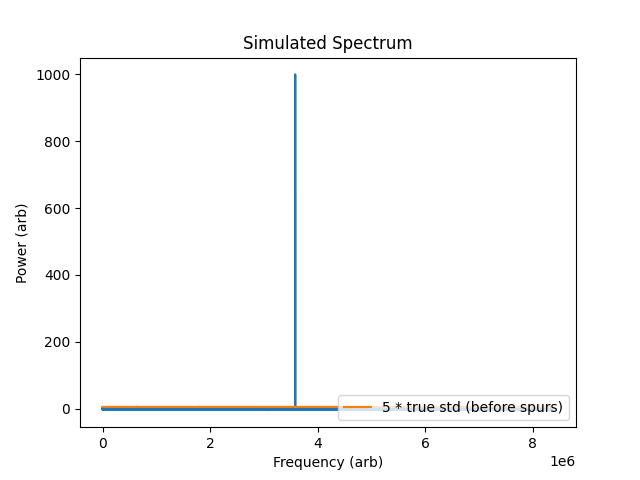

In [157]:
#generate test data (x)

#generate spectrum with known STD (sin^2)
testLength = 2**23
numStdPoints = 2**16
stds = 0.05*np.sin(np.linspace(0, 100*3.14, numStdPoints))**2 + 1
stdsInterp = 0.05*np.sin(np.linspace(0, 100*3.14, testLength))**2 + 1
x = np.random.normal(0, stds,  size=(testLength//numStdPoints, numStdPoints)) 
x = np.reshape(x.T, testLength)

#Inject spurs
x[int(testLength//2.34)] = 1000

plt.figure()
plt.title("Simulated Spectrum")
plt.plot(x)
plt.plot(np.linspace(0, testLength, numStdPoints), stds * 5, label = "5 * true std (before spurs)")
plt.xlabel('Frequency (arb)')
plt.ylabel('Power (arb)')
plt.legend(loc = 'lower right')

print('mean  = ', x.mean())
print('mad * 1.48 = ', 1.4826*sp.stats.median_abs_deviation(x))
print('std = ', np.std(x))


In [164]:
#rolling MAD, mp/shared memmory
#would be nice to wrap this in a function
window = 1000
step = 1
numProc = 46
spec = antSpecFiltered


def rollingMad(windowIdx):
    existing_shm    = shared_memory.SharedMemory(name=shm.name)
    startBuf        = windowIdx[0] * 8
    windowBufSize   = (windowIdx[1] - windowIdx[0]+1)
    window          = np.frombuffer(shm.buf, offset=startBuf, count=windowBufSize)
    output          = sp.stats.median_abs_deviation(window)
    return output


#Generate array of indicies of windows
#specWindoIdxSpanArr is a 2D array of shape (window,2). 
#Itterating over axis 0 gives len 2 arrays:
#arr[windowStartIdx, windowStopIdx]
specIdxArr              = np.arange(0,len(spec), 1)
specWindowIdxArr        = np.lib.stride_tricks.sliding_window_view(specIdxArr, window)[::step]
specWindowIdxSpanArr    = specWindowIdxArr[:,0::window-1]

#write spec to shared memmory
shm             = shared_memory.SharedMemory(create=True, size=spec.nbytes)
sharedSpec      = np.ndarray(spec.shape, dtype=spec.dtype, buffer=shm.buf) 
sharedSpec[:]   = spec[:] #need colon!

with mp.Pool(numProc) as p:
    rollingList = p.map(rollingMad, specWindowIdxSpanArr)



In [165]:

rollingMadArr = np.asarray(rollingList).reshape(-1)
filteredMadArr = dr.filterSpec(rollingMadArr, order = 2, fc_numBins = 20000, type = 'lowpass')
#pack into array with nan padding
filteredMadArrPad = np.full(len(spec), float('nan'))
filteredMadArrPad[window//2:-window//2+1] = filteredMadArr

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: operands could not be broadcast together with shapes (8388608,) (6990506,) 

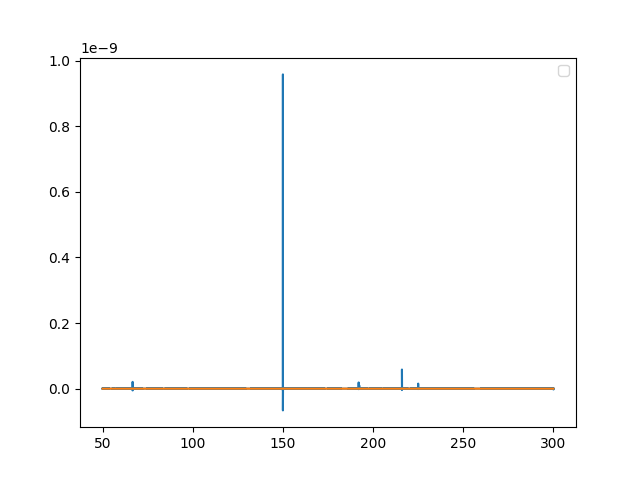

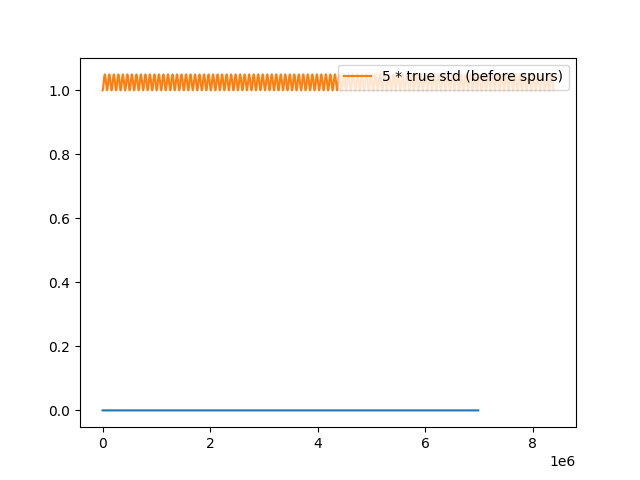

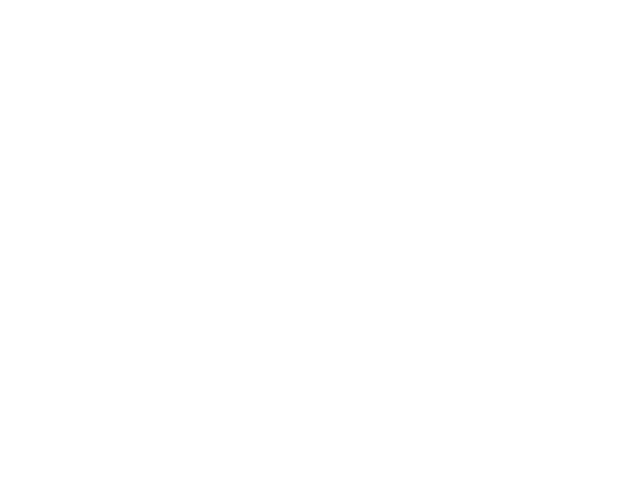

In [168]:
plt.close('all')
plt.figure()
plt.plot(freqs, antSpecFiltered)
#plt.plot(rollingMadArr*5*madCor)
plt.plot(freqs, filteredMadArrPad*5*madCor)
#plt.plot(np.linspace(0, testLength, numStdPoints), stds * 5, label = "5 * true std (before spurs)")
#plt.plot(dr.filterSpec(rollingMadArr*5*madCor, order = 2, fc_numBins = 1000, type = 'lowpass'), label = 'filtered rolling mad')
plt.legend(loc = 'upper right')


plt.figure()
plt.plot(filteredMadArrPad*madCor)
plt.plot(stdsInterp , label = "5 * true std (before spurs)")
plt.legend(loc = 'upper right')


plt.figure()
plt.plot((stdsInterp - madCor*filteredMadArrPad))

#plt.plot(rollingMadArr*5*madCor)
#plt.plot(dr.filterSpec(rollingMadArr*5*madCor, order = 2, fc_numBins = 500, type = 'lowpass'))


#plt.plot(((rollingMadMp*madCor)[1:] - stdsInterp)/stdsInterp)

stdErr = ((stdsInterp - madCor*filteredMadArrPad)/stdsInterp)
stdErrStd = stdErr[np.logical_not(np.isnan(stdErr))].std()
print(stdErrStd)





In [ ]:
#mp spcipy based homebrew 
#print(x)
window = 5000
step = 1
spec = x

strideSpec = np.lib.stride_tricks.sliding_window_view(spec,window)

#multiprocess rolling MAD on strided array
def MAD(spec):
    #print(spec)
    #return np.full(step, sp.stats.median_abs_deviation(spec))
    return sp.stats.median_abs_deviation(spec)
with mp.Pool(40) as p:
    rollingMadMp = p.map(MAD, strideSpec[::step])

rollingMadMp = np.asarray(rollingMadMp).reshape(-1)

'''
infArr = np.full(window//2, float('nan'))
rollingMadMp = np.append(infArr, rollingMadMp)
rollingMadMp = np.append(rollingMadMp, infArr)
'''


In [ ]:
window = 3
step = 2
spec = x
strideSpec = np.lib.stride_tricks.sliding_window_view(spec,window)
rollingMadMp = np.zeros(len(spec - window))

for i, spec in enumerate(strideSpec[::step]):
    rollingMadMp[i] = sp.stats.median_abs_deviation(spec)


In [ ]:
#ray multiprocessing (with shared read only memmory)

window = 1000
step = 1
#specLen = 2**16
#spec = np.random.normal(0,1,specLen)
spec = x
print('spec =  ')
print(spec)

ray.shutdown()
ray.init()

@ray.remote
def MAD(spec, windowIdx):
    return sp.stats.median_abs_deviation(spec[windowIdx[0]:windowIdx[1]+1])

data_id = ray.put(spec)
result_ids = []

specIdxArr = np.arange(0,len(spec), 1)
specWindowIdxArr = np.lib.stride_tricks.sliding_window_view(specIdxArr, window)[::step]
#2D array of shape (window,2) with start and stop idxs for windows
specWindowIdxSpanArr = specWindowIdxArr[:,0::window-1]

for windowIdx in specWindowIdxSpanArr:
    result_ids.append(MAD.remote(data_id, windowIdx))
results = np.asarray(ray.get(result_ids))

ray.shutdown()

plt.figure()
plt.plot(results*5*1.48)
plt.plot(spec)
plt.show()

plt.figure()
plt.hist(results)
plt.show()
    

In [ ]:
#plt.figure()
#plt.plot(rollingMadMp * madCor)
#plt.plot(stdsInterp)
print(len(rollingMadMp ))
print(len(stdsInterp))
print(len(rollingMadMp) - len(stdsInterp))


In [ ]:
x_df = pd.DataFrame(x)
#rollingMadPd = x_df.rolling(2000).apply(sp.stats.median_abs_deviation)
rollingStdPd = x_df.rolling(2000).std()
plt.figure()
plt.plot(x_df)
#plt.plot(rollingMadPd * 5 * 1.48, label = '5 * MAD *1.48')
plt.plot(rollingStdPd * 5, label = '5 * STD')
plt.plot(stdsInterp * 5, label = '5 * true std')
plt.legend(loc = 'lower right')
plt.xlabel('Freqency Index (arb)')
plt.ylabel('Linear Power (arb)')

In [ ]:
x_gpu = cp.array(x)

cp.median(cp.abs(x_gpu - cp.median(x_gpu)))

In [ ]:
np.median(np.abs(x - np.median(x)))

In [ ]:
#rolling std using pd rolling
antSpecFiltered = dr.filterSpec(antSpec)
termSpecFiltered = dr.filterSpec(termSpec)



antFilter_Df = pd.DataFrame(antSpecFiltered)
antRollingStd = antFilter_Df.rolling(10000).std()
termFilter_Df = pd.DataFrame(termSpecFiltered)
termRollingStd = termFilter_Df.rolling(10000).std()
termRollingMad = rollingMadMp

numTermCandidates = (termSpecFiltered > (6*termRollingStd).to_numpy().T[0]).sum()
numAntCandidates = (antSpecFiltered > (6*antRollingStd).to_numpy().T[0]).sum()
print(numTermCandidates, 'candidates on terminator')
print(numAntCandidates, 'candidates on antenna')

plt.figure()
plt.title('antenna')
plt.plot(antSpecFiltered)
plt.plot(antRollingStd*5)

plt.figure()
plt.title('terminator')
plt.plot(termSpecFiltered)
plt.plot(termRollingStd*5)
plt.plot(termRollingMad*5)

plt.figure()
plt.plot(antSpec)
plt.plot(termSpec)



In [ ]:
a = termSpecFiltered >np.array(rollingStd*5).T[0]

print(a.sum())
'''
def candidateSearch(spec, limit):
    boolArr = np.empty(len(spec), dtype=bool)
    for i in range(len(spec)):
        boolArr[i] = (spec[i] > limit[i])
    return boolArr

boolArr = candidateSearch(termSpecFiltered, np.array(rollingStd*5))
boolArr.sum()
'''

In [ ]:
plt.figure()
plt.plot(rollingMad)
plt.plot(rollingStd * .67)

In [ ]:


df = pd.DataFrame(antSpecCleanFilter)
arr = np.asarray(df.rolling(10000).std())
limit = 6 * arr

plt.figure()
plt.plot(freqs, antSpecCleanFilter)
plt.plot(freqs, limit, label = '5sigma thresh')

'''
count = 0
for i in range(len(antSpecCleanFilter)):
    if antSpecCleanFilter[i]>limit[i]:
        count += 1
print(count)
'''

In [ ]:
df = pd.DataFrame(antSpec)
arr = (df.rolling(100).median())
diff = (df - arr)
std = 5 * diff.rolling(10000).std()

plt.figure()
plt.plot(freqs, antSpec)
plt.plot(freqs,arr)

plt.figure()
plt.plot(freqs, diff)
plt.plot(freqs, std)



In [ ]:
plt.close('all')
plt.figure()
plt.plot(a)

In [ ]:
#show interleaving spur is single bin wide

plt.close('all')
plt.figure()
plt.scatter(freqs*1e6, dr.fft2dBm(antDataAll))
plt.xlabel('Freq (Hz)')
plt.ylabel('Power (dBm)')
plt.xlim(1.499990e8, 1.500010e8)
plt.ylim(-82,-58)

In [ ]:
parsedList, configDic = getParsedList('ConfigDR.ini', 'TEST');

avgSpec = dr.avgSpec(parsedList, '../../../../drBiggerBoy/drData/Data/', verbose=True)